
# Perceptual Hash + Fuzzy Extractor Demo (ResNet‑18 → FE → Crypto Tag)

This notebook shows an end-to-end demo:
1. Build a **perceptual binary code** `c(x)` from a ResNet-18 embedding (global average pooled) using a random projection and sign quantization.
2. Use that code for **Hamming-distance search** over a small image set.
3. Apply a **fuzzy extractor** (code-offset construction with Hamming(7,4) blocks) to derive a reproducible secret `R` and helper data `P`.
4. Derive a **cryptographic tag** `T` from `R` via HKDF + HMAC-SHA256.

> ⚠️ **Notes**
> - This is a *research demo*. For production, use stronger ECC (e.g., BCH/LDPC) and careful min-entropy accounting.
> - If pretrained weights cannot be fetched (no internet), the model will fall back to random weights (the search won’t be meaningful, but the pipeline runs).
> - Put sample images into an `images/` folder (JPEG/PNG).


In [1]:
import os, math, base64, random, hmac, hashlib
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    import torchvision
    from torchvision import transforms
    from torchvision.models import resnet18, ResNet18_Weights
    TV_OK = True
except Exception as e:
    TV_OK = False
    print("torchvision not available:", e)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)


Device: cuda



## 1) Image loading
Put some images into the `images/` folder. If it's empty, we will generate a few simple synthetic images.


из исходного файла images/0.07180100_1442390923_.jpg получаем:
* images/0.07180100_1442390923_stegano.jpg - с встроенной стеганографией (отдельные пиксели)
* images/0.07180100_1442390923_changed.jpg - с уменьшненой а 10% цветностью и размером (все пиксели) 

In [2]:

IMG_DIR = Path("images")
IMG_DIR.mkdir(exist_ok=True)

def load_images_from_folder(folder: Path, max_count: int = 64) -> List[Path]:
    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    files = [p for p in folder.iterdir() if p.suffix.lower() in exts]
    files.sort()
    return files[:max_count]

image_paths = load_images_from_folder(IMG_DIR, max_count=200)

# Fallback: create a few synthetic images if none provided
def make_synthetic_images(folder: Path, n: int = 6):
    colors = [(255,0,0), (0,255,0), (0,0,255),
              (255,255,0), (255,0,255), (0,255,255)]
    for i in range(n):
        img = Image.new("RGB", (224,224), colors[i % len(colors)])
        # simple pattern: add a small rectangle
        for x in range(80, 144):
            for y in range(100 + (i%3)*5, 160 + (i%3)*5):
                img.putpixel((x,y), tuple(255 - c for c in colors[i % len(colors)]))
        img.save(folder / f"synthetic_{i:02d}.png")

if not image_paths:
    print("No images found in 'images/'. Creating a few synthetic examples...")
    make_synthetic_images(IMG_DIR, n=6)
    image_paths = load_images_from_folder(IMG_DIR, max_count=64)

len(image_paths), image_paths[:5]


(140,
 [PosixPath('images/0.07180100_1442390923_.jpg'),
  PosixPath('images/0.07180100_1442390923_changed.jpg'),
  PosixPath('images/0.07180100_1442390923_stegano.jpg'),
  PosixPath('images/012038.jpg'),
  PosixPath('images/014-taal-crater-lake_586DA81BD8A34008B4CFFA1B2E206AFF.jpg')])


## 2) ResNet-18 embedding
We take global-average-pooled features (`d=512`). If pretrained weights are available, we use them; otherwise, we use random weights.


In [3]:

class ResNet18Embed(nn.Module):
    def __init__(self, pretrained: bool = True):
        super().__init__()
        if TV_OK:
            if pretrained:
                try:
                    m = resnet18(weights=ResNet18_Weights.DEFAULT)
                except Exception as e:
                    print("Failed to load pretrained weights, falling back to random:", e)
                    m = resnet18(weights=None)
            else:
                m = resnet18(weights=None)
            # remove classifier head; keep avgpool
            self.backbone = nn.Sequential(*(list(m.children())[:-1]))  # up to avgpool
            self.out_dim = 512
        else:
            # Minimal fallback: a tiny conv net (not meaningful)
            self.backbone = nn.Sequential(
                nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
            )
            self.out_dim = 16

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.backbone(x)  # [B, d, 1, 1]
        feat = feat.view(feat.size(0), -1)  # [B, d]
        feat = F.normalize(feat, p=2, dim=1)
        return feat

# preprocessing
if TV_OK:
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
else:
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])

embedder = ResNet18Embed(pretrained=True).to(device).eval()
print("Embedding dim:", embedder.out_dim)


Embedding dim: 512



## 3) Perceptual binary code: random projection + sign
We project to `n_bits` with a fixed Gaussian matrix `A` and threshold at zero.


In [4]:

# Choose n_bits for the code
n_bits = 512  # can be 256..2048 depending on speed/needs

rng = np.random.default_rng(42)
A = rng.standard_normal((n_bits, embedder.out_dim)).astype(np.float32)
b = np.zeros((n_bits,), dtype=np.float32)  # optional bias

A_t = torch.from_numpy(A).to(device)
b_t = torch.from_numpy(b).to(device)

def image_to_code(path: Path):
    img = Image.open(path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        v = embedder(x)                        # [1, d], L2-normalized
        z = F.linear(v, A_t, b_t)              # [1, n_bits]
    c = (z.cpu().numpy()[0] >= 0).astype(np.uint8)  # {0,1}^n
    return c, z.cpu().numpy()[0], v.cpu()

def hamming(a: np.ndarray, b: np.ndarray) -> int:
    return int(np.sum(a.astype(np.uint8) ^ b.astype(np.uint8)))

# Encode all images
db = []
for p in image_paths:
    c, z, v = image_to_code(p)
    db.append({"path": str(p), "code": c, "embed": z})

len(db)


140


## 4) Similarity search (Hamming)
Compute Hamming distances from a query to the database and list nearest neighbors.


In [5]:

def search_nearest(query_code: np.ndarray, topk: int = 5):
    scores = []
    for row in db:
        d = hamming(query_code, row["code"])
        scores.append((d, row["path"]))
    scores.sort(key=lambda x: x[0])
    return scores[:topk]

q_code, _, _ = image_to_code(Path(db[0]["path"]))
top = search_nearest(q_code, topk=5)
top


[(0, 'images/0.07180100_1442390923_.jpg'),
 (1, 'images/0.07180100_1442390923_stegano.jpg'),
 (9, 'images/0.07180100_1442390923_changed.jpg'),
 (69, 'images/a5f17e0b3dd5ed56bf5744f600b5c28b.jpg'),
 (86, 'images/a-golden-bedroom-with-a-feng-shui-glow.jpg')]

## 5) Fuzzy extractor (code-offset) with Hamming(7,4) blocks
Основные функции:

**`fe_gen(c_bits, blocks=64)`** → возвращает `dict` с:

* `helper_P` — публичный *helper* $P$ (биты упакованы и закодированы Base64);
* `R_hex` — хэш-секрет $R=\mathrm{SHA256}(w)$ в hex (в демо хранится для проверки);
* `K_hex` — ключ $K=\mathrm{HKDF}(R,\text{"FE-demo"})$ в hex (из него потом считают тег/HMAC);
* `blocks` — число 7-битовых кодовых блоков Хэмминга;
* `L` — сколько бит кода использовано $(L=7\cdot \text{blocks})$.

**`fe_rep(c_bits, helper)`** → возвращает `dict` с:

* `corrected_blocks` — сколько 7-битовых блоков исправил декодер Хэмминга;
* `R_hex` — восстановленный $R$ в hex;
* `K_hex` — восстановленный $K$ в hex;
* `match` — булево, совпал ли восстановленный $R$ с эталоном из `helper` (успех репродукции).




In [6]:

import numpy as np, base64, hmac, hashlib

# Hamming(7,4)
G = np.array([
    [1,0,0,0, 0,1,1],
    [0,1,0,0, 1,0,1],
    [0,0,1,0, 1,1,0],
    [0,0,0,1, 1,1,1],
], dtype=np.uint8)

H = np.array([
    [1,1,0,1, 1,0,0],
    [1,0,1,1, 0,1,0],
    [0,1,1,1, 0,0,1],
], dtype=np.uint8)

syndrome_to_bit = {
    (1,0,0): 4, (0,1,0): 5, (0,0,1): 6,
    (1,1,0): 0, (1,0,1): 1, (0,1,1): 2, (1,1,1): 3,
}

def ham_encode_block(m4):
    cw = (m4 @ G) % 2
    return cw.astype(np.uint8)

def ham_decode_block(y7):
    s = (H @ y7) % 2
    key = tuple(int(x) for x in s.tolist())
    corrected = False
    cw = y7.copy()
    if key != (0,0,0):
        pos = syndrome_to_bit.get(key, None)
        if pos is not None:
            cw[pos] ^= 1
            corrected = True
    return cw, corrected

def ham_extract_message(cw7):
    return cw7[:4].astype(np.uint8)

def ham_encode_message(m_bits):
    assert m_bits.ndim == 1 and (len(m_bits) % 4 == 0)
    out = []
    for i in range(0, len(m_bits), 4):
        out.append(ham_encode_block(m_bits[i:i+4]))
    return np.concatenate(out, axis=0).astype(np.uint8)

def ham_decode_codeword(y_bits):
    assert y_bits.ndim == 1 and (len(y_bits) % 7 == 0)
    out = []; corrected = 0
    for i in range(0, len(y_bits), 7):
        cw, corr = ham_decode_block(y_bits[i:i+7])
        out.append(cw); corrected += int(corr)
    return np.concatenate(out, axis=0).astype(np.uint8), corrected

def bits_to_bytes(bs: np.ndarray) -> bytes:
    pad = (-len(bs)) % 8
    if pad: bs = np.concatenate([bs, np.zeros(pad, dtype=np.uint8)])
    return np.packbits(bs, bitorder='big').tobytes()

def sha256_hex(data: bytes) -> str:
    return hashlib.sha256(data).hexdigest()

def hkdf_extract_expand(key_material: bytes, info: bytes = b'ctx', out_len: int = 32) -> bytes:
    prk = hmac.new(b'\x00'*32, key_material, hashlib.sha256).digest()
    t = b''; okm = b''; counter = 1
    while len(okm) < out_len:
        t = hmac.new(prk, t + info + bytes([counter]), hashlib.sha256).digest()
        okm += t; counter += 1
    return okm[:out_len]

def fe_gen(c_bits: np.ndarray, blocks: int = 64):
    L = 7 * blocks
    x = (np.array(c_bits[:L], dtype=np.uint8) & 1)

    # 1) На этапе Gen СНАЧАЛА «нормализуем» каждый 7-битный блок до ближайшего кодового слова
    #    (ровно тем же декодером, что будет у Rep)
    code, corrected_gen = ham_decode_codeword(x)  # длина L, исправляет ≤1 ошибку на блок

    # 2) Offset = code ^ x (ровно под тот же 'code', который мы только что зафиксировали)
    P_bits  = (code ^ x).astype(np.uint8)
    P_bytes = np.packbits(P_bits, bitorder='big').tobytes()
    helper_P_b64 = base64.b64encode(P_bytes).decode('ascii')

    # 3) Материал привязки и ключ — от ИМЕННО ЭТОГО 'code'
    R_hex = hashlib.sha256(bits_to_bytes(code)).hexdigest()
    K_hex = hkdf_extract_expand(bytes.fromhex(R_hex), info=b'FE-demo', out_len=32).hex()

    return {
        "blocks": blocks,
        "L": L,
        "helper_P": helper_P_b64,
        "R_hex": R_hex,
        "K_hex": K_hex,
        "corrected_blocks_enroll": int(corrected_gen),  # полезно для дебага
    }

def fe_rep(c_bits: np.ndarray, helper):
    L = int(helper["L"])
    x = (np.array(c_bits[:L], dtype=np.uint8) & 1)

    P_bytes = base64.b64decode(helper["helper_P"])
    P_arr   = np.frombuffer(P_bytes, dtype=np.uint8)
    P_bits  = np.unpackbits(P_arr, bitorder='big')[:L]

    # y = code ⊕ noise  (при нулевом шуме будет ровно code)
    y = (x ^ P_bits).astype(np.uint8)

    # декодируем до ближайшего кодового слова тем же алгоритмом
    y_dec, corrected = ham_decode_codeword(y)

    R_hex = hashlib.sha256(bits_to_bytes(y_dec)).hexdigest()
    K_hex = hkdf_extract_expand(bytes.fromhex(R_hex), info=b'FE-demo', out_len=32).hex()

    ok = (R_hex == helper["R_hex"])
    return {"corrected_blocks": int(corrected), "R_hex": R_hex, "K_hex": K_hex, "match": ok}



def hmac_sha256_hex(key: bytes, msg: bytes) -> str:
    return hmac.new(key, msg, hashlib.sha256).hexdigest()

def derive_tag_from_helper(helper, meta: str = "record:0") -> str:
    K = bytes.fromhex(helper["K_hex"])
    return hmac_sha256_hex(K, meta.encode("utf-8"))



### Demo FE on one entry


In [7]:

c0 = db[0]["code"]
helper0 = fe_gen(c0, blocks=64)  # uses first 448 bits
rep0 = fe_rep(c0, helper0)
T0 = derive_tag_from_helper(helper0, meta="record:0")
print(f"Helper: {helper0}")
print(f"Repair для того же Img: {rep0}")
print(f"Tag: {T0}")


Helper: {'blocks': 64, 'L': 448, 'helper_P': 'QARAIDAICCECAQAgSAQIAACASAIIAAARCAgAkICACCAhAAQIBQEBEAEICABCAICCEAQAIAgICEA=', 'R_hex': '753c2a53de4366e6324058091e5a4c1351a45f1e27c36f6b208ce057559645b7', 'K_hex': '9d3e214924bc0692cea4441356677bd28b828f703de16a22b82a3fffa3375c16', 'corrected_blocks_enroll': 56}
Repair для того же Img: {'corrected_blocks': 0, 'R_hex': '753c2a53de4366e6324058091e5a4c1351a45f1e27c36f6b208ce057559645b7', 'K_hex': '9d3e214924bc0692cea4441356677bd28b828f703de16a22b82a3fffa3375c16', 'match': True}
Tag: 97057546884f988e0888b3bcd2f4e22fdce9764c162d3e02e80c756f3a100b57



### Perturbation test (flip one bit per block across 10 blocks)
пробуем портить бинарное представление, восстанавливаем и срваниваем 

In [8]:

def flip_bits(bits: np.ndarray, idxs):
    b = bits.copy()
    for i in idxs:
        if 0 <= i < len(b): b[i] ^= 1
    return b

c_perturb = c0.copy()
for blk in range(10):
    pos = blk*7 + (blk % 7)
    c_perturb[pos] ^= 1
    # c_perturb[pos+1] ^= 1 ## 2 ошибки в одном блоке

rep1 = fe_rep(c_perturb, helper0)
print(f"Helper original: {helper0}")
print(f"Repaired flipped: {rep1}")


Helper original: {'blocks': 64, 'L': 448, 'helper_P': 'QARAIDAICCECAQAgSAQIAACASAIIAAARCAgAkICACCAhAAQIBQEBEAEICABCAICCEAQAIAgICEA=', 'R_hex': '753c2a53de4366e6324058091e5a4c1351a45f1e27c36f6b208ce057559645b7', 'K_hex': '9d3e214924bc0692cea4441356677bd28b828f703de16a22b82a3fffa3375c16', 'corrected_blocks_enroll': 56}
Repaired flipped: {'corrected_blocks': 10, 'R_hex': '753c2a53de4366e6324058091e5a4c1351a45f1e27c36f6b208ce057559645b7', 'K_hex': '9d3e214924bc0692cea4441356677bd28b828f703de16a22b82a3fffa3375c16', 'match': True}



## 6) Whole DB: build helpers/tags, search + verify
* в БД достаточно хранить Значения helper0["helper_P"] и T0 (см пп "Demo FE on one entry"). Для поиска и верификации этого достаточно, если нужно безопасно. Для эффективного поиска нужен отдельный индекс по коду (напр., c(x)/LSH), иначе будет O(N).

* И это не эквивалент классическому хешированию, сопоставимый по надёжности, но формально другой примитив.
По подделке/целостности не хуже (HMAC даёт криптостойкость уровня хешей), но по приватности слабее классического безключевого хеша, т.к. публичный helper несёт ограниченную утечку и позволяет проверки принадлежности — это осознанный компромисс ради поиска (ради этого и задумано исследование).


In [9]:

# Build FE helper + tag for each DB entry
for i,row in enumerate(db):
    c = row["code"]
    helper = fe_gen(c, blocks=64)
    row["fe_helper"] = helper
    row["tag"] = derive_tag_from_helper(helper, meta=f"record:{i}")

# Query
q_code, _, _ = image_to_code(Path(db[0]["path"]))
cands = []
for row in db:
    d = hamming(q_code, row["code"])
    cands.append((d, row))
cands.sort(key=lambda x: x[0])
cands = cands[:5]

print(f'Compare images from DB with img {Path(db[0]["path"])}\n===')
results = []
for d, row in cands:
    rep = fe_rep(q_code, row["fe_helper"])
    tag_q = hmac_sha256_hex(bytes.fromhex(rep["K_hex"]), f"record:{db.index(row)}".encode())
    verified = (tag_q == row["tag"]) and rep["match"]
    results.append({"path": row["path"], "ham": d, "FE_match": rep["match"], "tag_q":tag_q, "row_tag":row["tag"], "verified": verified})
    print(f"--check record {db.index(row)} from DB")
    report = {"path": row["path"], "ham": d, "FE_match": rep["match"], "tag_q":tag_q, "row_tag":row["tag"], "verified": verified}
    print(f'   record {"math" if report["verified"] else "not match"}: {report}')
    



Compare images from DB with img images/0.07180100_1442390923_.jpg
===
--check record 0 from DB
   record math: {'path': 'images/0.07180100_1442390923_.jpg', 'ham': 0, 'FE_match': True, 'tag_q': '97057546884f988e0888b3bcd2f4e22fdce9764c162d3e02e80c756f3a100b57', 'row_tag': '97057546884f988e0888b3bcd2f4e22fdce9764c162d3e02e80c756f3a100b57', 'verified': True}
--check record 2 from DB
   record math: {'path': 'images/0.07180100_1442390923_stegano.jpg', 'ham': 1, 'FE_match': True, 'tag_q': '1f69538518666a149a280f57e4ae168d887ffefdef64c289cdb02560e7c0cedd', 'row_tag': '1f69538518666a149a280f57e4ae168d887ffefdef64c289cdb02560e7c0cedd', 'verified': True}
--check record 1 from DB
   record math: {'path': 'images/0.07180100_1442390923_changed.jpg', 'ham': 9, 'FE_match': True, 'tag_q': 'cb20bdfdf1c5f1a59311503f04180cdf33a600eb889f2408330952a5102f2f80', 'row_tag': 'cb20bdfdf1c5f1a59311503f04180cdf33a600eb889f2408330952a5102f2f80', 'verified': True}
--check record 138 from DB
   record not match: {


# Experiments: Intra-robustness & Inter-separability

Дополнение к разделу статьи *«Практическая проверка. Мы проводим два эксперимента»*.

## Эксперимент 1 — Intra-робастность
* представлен набор лёгких преобразований Ts (resize, небольшой RandomRotation, ColorJitter) — они соответствуют проверкам из статьи (intra‑BER под допустимыми искажениями).
* вывожу 95‑й перцентиль и рекомендованный радиус исправления t в битах.


Intra robustness results: mu=0.147, sigma=0.026, q95=0.172, recommended t≈88 bits (n=512)


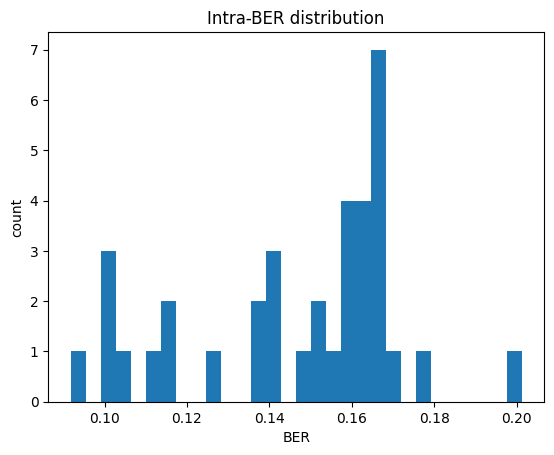

In [14]:
# --- Intra-робастность (fixed to use `image_paths` and existing pipeline) ---
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms

rng = np.random.default_rng(0)

def ber(a, b):
    a = np.asarray(a, dtype=np.uint8)
    b = np.asarray(b, dtype=np.uint8)
    assert a.shape == b.shape, f"Codes must have same shape, got {a.shape} vs {b.shape}"
    return float((a ^ b).mean())

# Берём небольшую подвыборку из ранее загруженной коллекции
assert len(image_paths) > 0, "No images found in image_paths. Please run the loading cell."
test_images = image_paths[:min(12, len(image_paths))]

# Лёгкие детерминированные/слабо-стохастические преобразования
Ts = [
    transforms.Compose([transforms.Resize((224, 224))]),
    transforms.Compose([transforms.Resize((224, 224)), transforms.RandomRotation(5)]),
    transforms.Compose([transforms.Resize((224, 224)), transforms.ColorJitter(brightness=0.1, contrast=0.1)]),
]

def code_from_pil(img):
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        v = embedder(x)                        # [1, d], L2-normalized
        z = F.linear(v, A_t, b_t)              # [1, n_bits]
    return (z.cpu().numpy()[0] >= 0).astype(np.uint8)

ber_values = []
for p in test_images:
    img0 = Image.open(p).convert("RGB")
    c0 = code_from_pil(img0)
    for T in Ts:
        imgT = T(img0)
        cT = code_from_pil(imgT)
        ber_values.append(ber(c0, cT))

ber_values = np.array(ber_values, dtype=float)
mu = float(ber_values.mean())
sigma = float(ber_values.std())
q95 = float(np.quantile(ber_values, 0.95))

# Длину кода берём из реального кода изображения
n_bits = len(image_to_code(test_images[0])[0])
t_bits = int(round(n_bits * q95))

print(f"Intra robustness results: mu={mu:.3f}, sigma={sigma:.3f}, q95={q95:.3f}, recommended t≈{t_bits} bits (n={n_bits})")

plt.figure()
plt.hist(ber_values, bins=30)
plt.title("Intra-BER distribution")
plt.xlabel("BER")
plt.ylabel("count")
plt.show()



## Эксперимент 2 — Inter-разделимость
Посчитал бинарные коды через image_to_code(p)[0] для всех изображений.
Сэмплинг случайных разных пар и расчёт нормированного Хэмминга, медианы и массы слева от порога (например, ≤ 0.3) — как описано в статье (inter‑распределение должно быть около 0.5).

Inter separability: median=0.307, mass[0,0.3]=42.549% (n=512, pairs=1389)


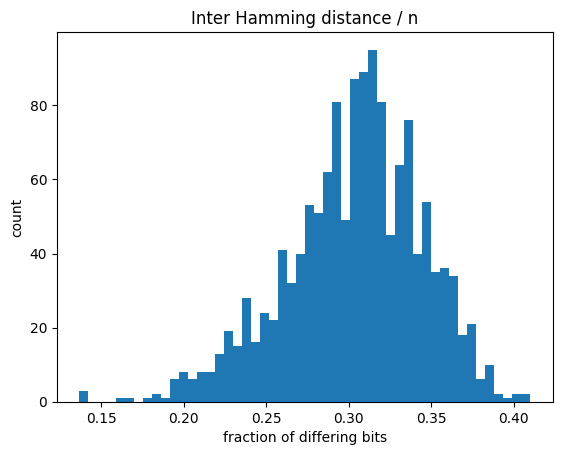

In [15]:
# --- Inter-разделимость (fixed to use `image_paths` and existing pipeline) ---
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1)

# Галерея из ранее загруженной коллекции
gallery_images = image_paths
assert len(gallery_images) >= 2, "Need at least 2 images to compute inter separability."

# Бинарные коды всех изображений
codes = [image_to_code(p)[0] for p in gallery_images]
n = len(codes[0])

# Сэмплируем разные пары
M = len(codes)
m = min(5000, M * 10)
pairs = rng.integers(0, M, size=(m, 2))
pairs = pairs[pairs[:, 0] != pairs[:, 1]]
if len(pairs) == 0 and M >= 2:
    pairs = np.array([(i,j) for i in range(M) for j in range(i+1, M)], dtype=np.int64)

# Нормированный Хэмминг
dists = []
for i, j in pairs:
    a = np.asarray(codes[i], dtype=np.uint8)
    b = np.asarray(codes[j], dtype=np.uint8)
    dists.append(float((a ^ b).mean()))
dists = np.array(dists, dtype=float)

med = float(np.median(dists))
mass_low = float((dists <= 0.3).mean())

print(f"Inter separability: median={med:.3f}, mass[0,0.3]={mass_low:.3%} (n={n}, pairs={len(dists)})")

plt.figure()
plt.hist(dists, bins=50)
plt.title("Inter Hamming distance / n")
plt.xlabel("fraction of differing bits")
plt.ylabel("count")
plt.show()

